# TP8: Deep Learning

Prof. L. Jacques
Prof. C. De Vleeschouwer 

Benoit Brummer (benoit.brummer@uclouvain.be)<br />
Anne-Sophie Collin (anne-sophie.collin@uclouvain.be)<br />
Olivier Leblanc (o.leblanc@uclouvain.be)<br />
Gabriel Van Zandycke (gabriel.vanzandycke@uclouvain.be)<br />

<div style="text-align: right"> 2021-2022</div>

This practical session provides an introduction to the wonderful world of Deep Learning. We will demonstrate practical examples using the `PyTorch` framework.

Since there's too much content to digest and apply by yourself in a two hours session, this exercice session will take a rather unusual turn: we will provide most of the code and guide you through it step-by-step explaining the details.

There will be two consecutive deep learning sessions. In this first one, we focus on the basic building blocks needed in a deep learning pipeline and we use them to build a classification task. The next one will focus more on image generation.

You are welcome to experiment with the parameters and explore ways to make your model(s) work better.

Because training neural networks is very resource intensive, we recommend running this session on Google Colab (unless you have a CUDA-capable Nvidia GPU). To do so, simply upload the notebook on https://colab.research.google.com . We posted the necessary files on an external server and automatically download them to make it easier.


In [1]:
import random
import time
import statistics
import os
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

if os.path.exists('utils.py') and os.path.exists('test_images'):
    import utils
else:
    # we will download necessary files to make it easier to deal with colab
    import requests
    r = requests.get('http://207.180.227.42:84/lelec2885_tp8/utils.py', allow_redirects=True)
    open('utils.py', 'wb').write(r.content)
    import utils
    r = requests.get('http://207.180.227.42:84/lelec2885_tp8/test_images.zip', allow_redirects=True)
    open('test_images.zip', 'wb').write(r.content)
    import zipfile
    with zipfile.ZipFile('test_images.zip', 'r') as zip_ref:
        zip_ref.extractall('test_images')

## 0. The PyTorch framework

In the past exercices sessions, you've gotten familiar with several Python frameworks (numpy, scikit-learn,...). They provide a set of functions and classes which are useful when solving specific type of problems. PyTorch is a similar framework that is useful for training neural networks. Other such frameworks exist like Tensorflow (which we won't cover in this session).

PyTorch enables one to:
- run code on CPU and/or GPU and easily transfer data from one to the other. GPUs are orders of magnitude faster than CPUs for training neural networks.
- automatically computes gradients which needed to optimize the network with the backpropagation algorithm.

The most important resource is PyTorch' documentation, which you can find on https://pytorch.org/docs/stable/index.html under "Python API".

## 1. Neural networks

### a. Tensors

Like Numpy, PyTorch uses tensors which are multi-dimension arrays. When representing an image, the data format is typically (batch_size, num_channels, height, width) or (B,C,H,W).

Training is typically done on many images in parallel, thus using a large batch_size.

The [torch](https://pytorch.org/docs/stable/torch.html) package provides functions and attributes that take tensors as arguments, as well as the ability to create tensors.

Per the [torch documentation](https://pytorch.org/docs/stable/torch.html), you can create a random tensor of shape (1,3,32,32) as follow:


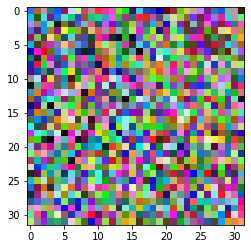

In [2]:
a_random_image = torch.rand(1,3,32,32)

# we provide you with a convenient pytorch tensor display function
utils.display_pt_img(a_random_image, zoom=True)

A tensor is actually a computational graph, not just an array. Everything you do to it is tracked, so that PyTorch can compute the gradient and backpropagate all the way from a loss score to the original input data, and optimize the networks' parameters to minimize that loss.

### b. Layers

Layers are classes which define operations that a network will perform on given tensors. They may (and often do) contain trainable parameters, such as the weights used in the convolution layer.

A layer in pytorch is a subclass of the `torch.nn.Module` object. It must have the following two methods implemented:
 - `__init__` constructor: The layer's components (and their associated weights) are defined and initialized here. A layer may even contain other layers.
 - `forward`: This function is called whenever data is passed through the network (ie calling an initialized layer is equivalent to calling its forward method). It connects the different building blocks in the desired way.
 
PyTorch comes with many layers which are defined and documented in [torch.nn documentation](https://pytorch.org/docs/stable/nn.html).

Today we are looking closely at the following pre-defined layers:

#### 0. Linear

A linear layer simply applies a linear transformation $\text{output}=\text{input} \times \text{weights}^T + \text{bias}$ to the data x.

It is defined as [torch.nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear) and used as follow:




In [ ]:
a_linear_layer = torch.nn.Linear(in_features = 3*32**2, out_features=10)
transformed_input = a_linear_layer(a_random_image.flatten())
print(f'The output of this linear layer has shape {transformed_input.shape}')

The output of this linear layer has shape torch.Size([10])


#### 1. Convolution

Convolutions are arguably the main part of a convolutional neural network. The convolution has a kernel of size $k\times C_{in}\times C_{out}$ (where a typical value for k is 3) that slides over its input features, as shown below:

![convolution](https://upload.wikimedia.org/wikipedia/commons/0/04/Convolution_arithmetic_-_Padding_strides.gif)
<center><small>(Image authors: Vincent Dumoulin and Francesco Visin, MIT license)</small></center>

The following figure shows a k=3 * C<sub>in</sub>=3 kernel applied to a RGB image. There is one such kernel (with different weights) for every output channel of the convolution.

![convolution2](https://upload.wikimedia.org/wikipedia/commons/9/95/Convolutional_Neural_Network_with_Color_Image_Filter.gif)
<center><small>(Image author: Cecbur, CC-BY-SA-4.0 license)</small></center>

You will find the 2D convolution documented in [torch.nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d).

The following tool can help you visualize the effect of different parameters: https://ezyang.github.io/convolution-visualizer/

Some advantages of convolutions (and purely convolutional neural networks) are that the kernel has relatively few weights which are reused across the spatial dimensions, and it can operate on any size input without any modification.

You can initialize a convolution (with untrained weights) and use it as follow:




In [ ]:
untrained_convolution = torch.nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=0)
convolved_random_image = untrained_convolution(a_random_image)
print(f'Convolved image has shape {convolved_random_image.shape}')

Convolved image has shape torch.Size([1, 32, 30, 30])


Question: Can you explain why the image shape has gone from (1,3,32,32) to (1, 32, 30, 30)?
=> Parce qu'on s'arrête à l'avant dernier pixel lorsque le kernel passe sur l'image.

#### 2. Non-linear activation function

Activation functions are usually found after a convolution. They can change the output values of a convolution and introduce non-linearities by thresholding them. These non-linearities are what gives neural networks the expressiveness needed to approximate any given function.

PyTorch includes many non-linear activation functions documented on [nn.html#non-linear-activations-weighted-sum-nonlinearity](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity).

One widely used activation function is the ReLU (defined in PyTorch as [torch.nn.ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU)). It is a simple thresholding function where output = max(0, input), yet it is highly effective.

Even though the ReLU needs no parameters and has no trainable weights, it is initialised like any layer.

![relu](https://pytorch.org/docs/stable/_images/ReLU.png)


In [ ]:
arelu = torch.nn.ReLU()
print(f"The convolved random image has min={convolved_random_image.min()}, avg={convolved_random_image.mean()}")
convolved_random_image = arelu(convolved_random_image)
print(f"After ReLU activation, the convolved random image has min={convolved_random_image.min()}, avg={convolved_random_image.mean()}")

The convolved random image has min=-1.0214751958847046, avg=0.15901492536067963
After ReLU activation, the convolved random image has min=0.0, avg=0.22373339533805847


#### 3. Downsampling

Sometimes we may want to downsample the spatial dimensions of a given layer, for example to save on the computing cost.

Most of those PyTorch layers are defined in [torch.nn#pooling-layers](https://pytorch.org/docs/stable/nn.html#pooling-layers). Here we will use the [torch.nn.MaxPool2d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d) function, which downsamples by taking the maximum value (though you are welcome to try different pooling functions like [torch.nn.AvgPool2d](https://pytorch.org/docs/stable/generated/torch.nn.AvgPool2d.html#torch.nn.AvgPool2d) and see if you obtain better or worse results).

The following code will downsample by a factor of two:


In [ ]:
downsampler = torch.nn.MaxPool2d(kernel_size=2)
downsampled_features = downsampler(convolved_random_image)
print(f'Latent space shape after downsampling: {downsampled_features.shape}, avg: {downsampled_features.mean()}')

Latent space shape after downsampling: torch.Size([1, 32, 15, 15]), avg: 0.35034680366516113


#### 4. Custom layers

Last but not least, we can define custom layers by inheriting from torch.nn.Module and implementing the __init__ and forward functions.

The following custom layer adds random noise in the range [-0.5,0.5] * scale to a given input:


In [ ]:
class RandomNoiseAdder(torch.nn.Module):
    """This layer adds random noise in the range [-0.5, 0.5]*scale to its input."""

    def __init__(self, scale: float):
        super().__init__()
        self.scale = scale

    def forward(self, input_tensor):
        return input_tensor + (torch.rand_like(input_tensor) - 0.5) * self.scale

noise_adder = RandomNoiseAdder(scale=1)
noisy_features = noise_adder(downsampled_features)

### c. Network
A network is typically composed of multiple layers and it behaves as one: it must have an __init__ function and a forward function.

Both a layer and a whole network inherit from the torch.nn.Module superclass. They are effectively the same thing as there is no distinction between the two; any module can contain any number of other modules and a simple layer can be trained the same way as if it were a network.

As a first example we will show the very pointless yet simple example of a network which adds uniform random noise to an image then inverts it. 




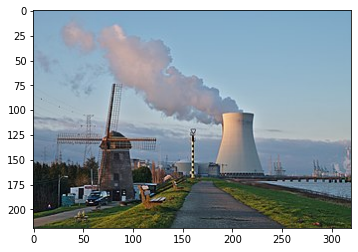

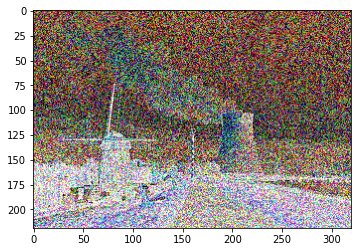

In [ ]:
class NoisyInverter(torch.nn.Module):
    """This network adds random noise and inverts a given image."""
    
    def __init__(self, scale):
        """Define the networks' building blocks."""
        super().__init__()
        self.noise_adder = RandomNoiseAdder(scale=scale)
    
    def forward(self, input_tensor):
        """Define the mapping from input to output."""
        x = self.noise_adder(input_tensor)  # use our noise layer
        x = 1-x  # invert
        return torch.clip(input=x, min=0, max=1)  # clip to useful [0,1] range and return

# get an input image and display it
img_fpath = utils.get_random_testimg_fpath(category='misc')
img_tensor = utils.img_fpath_to_pt_tensor(img_fpath)
utils.display_pt_img(img_tensor, zoom=False)

# apply our pointless network and display the result
noisy_inverter = NoisyInverter(scale=1)
noisy_inverted_image = noisy_inverter(img_tensor)
utils.display_pt_img(noisy_inverted_image, zoom=False)

The only noticeable difference with the simple layer is that it itself contains a layer, but there are still no learnable parameters.

Luckily we want to learn something useful.

In this practical session, we want to define a network which can classify images from the [CIFAR10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html); we know that the input images are $32\times 32$ pixels hence the network can expect an **input** with shape **(batch_size,3,32,32)**, and the **output** of the forward method should be an array of 10 scores, each representing the likelihood of one of the **10 classes** (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck).

Let's try to define a network capable of accomplishing this task: we want some convolutions which will be trained, ReLU activations, at some point we can downsample the features to reduce complexity, and finally we use one or two linear (fully connected) layers which transform the latent features from a 2D representation to a 1D array of 10 classes.


input image: 


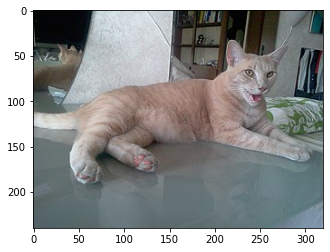

scaled image:


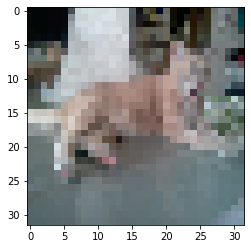

network output: tensor([[-0.0294,  0.0161,  0.0127, -0.0623,  0.0591, -0.0754, -0.0689,  0.0286,
         -0.0443,  0.0273]], grad_fn=<AddmmBackward0>)
The network predicted the class "deer"


In [ ]:
CLASSES = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

class Classifier_CNN(torch.nn.Module):
    """
    Simple classifier neural network for 32x32 images.

    somewhat similar to that defined on
    https://pytorch.org/tutorials/recipes/recipes/defining_a_neural_network.html
    
    Feel free to change things around!
    """

    def __init__(
        self, num_classes: int, input_spatial_dimension: int, latent_channels: int = 64
    ):
        """
        Model initialization.

        Here we define all of the building blocks of our neural network,
        including any weights that need to be trained.

        This structure is rather arbitrary, you are free to experiment with
        different networks that respect the input and output dimensions.

        See https://pytorch.org/docs/stable/nn.html for a long list of
        possibilities and their documentation.

        Parameters:
            input_dimensions: int:
                height and width of input images (must be the same)
            num_classes: int:
                number of classes (categories)
            latent_channels: int:
                number of feature ("hidden" or "latent") channels in most
                convolution layers.
                Increasing this value increases the network's complexity.

        """
        super().__init__()
        self.activation = torch.nn.ReLU()
        # we start with 3 input channels (RGB) and we progressively increase the
        # number of channels to match the latent_channels parameter.
        # The beginning of the network will focus on simple edges while the end
        # captures more complex features.

        self.convolution1 = torch.nn.Conv2d(
            in_channels=3, out_channels=latent_channels // 2, kernel_size=3, padding=0
        )
        self.convolution2 = torch.nn.Conv2d(
            in_channels=latent_channels // 2,
            out_channels=latent_channels,
            kernel_size=3,
            padding=0,
        )

        # We can reduce complexity a bit by reducing the spatial dimensions
        self.downsample = torch.nn.MaxPool2d(kernel_size=2)

        self.convolution3 = torch.nn.Conv2d(
            in_channels=latent_channels,
            out_channels=latent_channels,
            kernel_size=3,
            padding=0,
        )
        self.convolution4 = torch.nn.Conv2d(
            in_channels=latent_channels,
            out_channels=latent_channels,
            kernel_size=3,
            padding=0,
        )
        # 32x32 => 30X30 => 28x28 => 14x14 => 12x12 => 10x10x64 (64 = # de channels)
        num_features_post_convolution: int = 6400  # TODO by students.
        # For the fully connected layer, we want to pass all features (2D) to a
        # linear layer (1D).
        # use the forward definition below to figure out the shape and number of
        # features between the last convolution and the fully connected layer.
        # There will be CxHxW features in the latent space.
        # https://ezyang.github.io/convolution-visualizer/ can be useful

        self.fully_connected1 = torch.nn.Linear(
            in_features=num_features_post_convolution, out_features=latent_channels * 2
        )
        self.fully_connected2 = torch.nn.Linear(
            in_features=latent_channels * 2, out_features=num_classes
        )

    def forward(self, input_batch):
        """
        Define how the different building blocks are used and interconnected.

        input: input batch of images (dimensions: batch_size, channels, height, width)
        output: one score per class (dimensions: num_classes)

        Here you can do anything as long as it is differentiable (if it affects
        the result). PyTorch will automatically take care of the backward pass.

        You are also free to do anything which does not affect the result, like
        throwing print and debug statements.
        """
        x = self.convolution1(input_batch)
        x = self.activation(x)
        x = self.activation(self.convolution2(x))
        x = self.downsample(x)
        x = self.activation(self.convolution3(x))
        x = self.activation(self.convolution4(x))
        x = self.fully_connected1(x.flatten(start_dim=1))  # we don't want to flatten the batch dimension
        x = self.fully_connected2(x)
        return x

# Let's test this network

# get a test image
catimg_fpath = utils.get_random_testimg_fpath(category='cat')
catimg_tensor = utils.img_fpath_to_pt_tensor(catimg_fpath)
print('input image: ')
utils.display_pt_img(catimg_tensor)

# instantiate the network
model = Classifier_CNN(num_classes=10, input_spatial_dimension=32, latent_channels=64)
# classify our image
catimg_tensor_32 = torchvision.transforms.Resize((32,32))(catimg_tensor) # make sure it is 32x32 px
print('scaled image:')
utils.display_pt_img(catimg_tensor_32, zoom=True)

model_out = model(catimg_tensor_32)
print(f'network output: {model_out}')

result = CLASSES[torch.argmax(model_out)]  # Take the class with the highest score, that is the network's prediction
print(f'The network predicted the class "{result}"')

This network takes in a 32x32 image and outputs a score for 10 different classes. Success so far! Of course the result is completely meaningless; the network's convolution weights have not yet been optimized so the output is random.

## 3. Loss function

In order to assess the performance of our network and optimize it, we need a (differentiable) loss function which compares the network's output to an ideal result.

PyTorch provides many such loss functions defined in [[nn#loss-functions]](https://pytorch.org/docs/stable/nn.html#loss-functions). Which one to use depends on the use-case and the type of data.

If we were to compare a generated or corrupted image with an ideal target, we could simply take the difference between the two (aka the [L1Loss](https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html#torch.nn.L1Loss), or the squared difference ([MSELoss](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss) or L2) to penalize large differences more strongly:


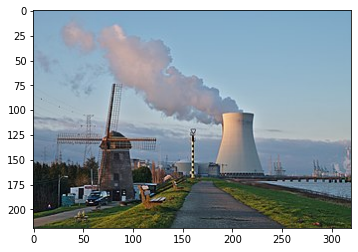

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


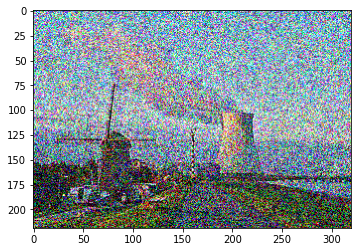

L1 loss between the clean and noisy image is 0.2500288784503937
Manually computed L1 loss is 0.2500288784503937
Mean square error between the clean and noisy image is 0.08339085429906845


In [ ]:
# Show the data
noisy_img_tensor = noise_adder(img_tensor)
utils.display_pt_img(img_tensor)
utils.display_pt_img(noisy_img_tensor)

# L1 loss
l1loss = torch.nn.L1Loss()
l1loss_result = l1loss(img_tensor, noisy_img_tensor)
print(f"L1 loss between the clean and noisy image is {l1loss_result}")

# This manually defined loss should be equivalent to the provided L1Loss class.
l1loss_manual_result = (img_tensor-noisy_img_tensor).abs().mean()
print(f"Manually computed L1 loss is {l1loss_manual_result}")

# L2 loss
l2loss = torch.nn.MSELoss()
l2loss_result = l2loss(img_tensor, noisy_img_tensor)
print(f"Mean square error between the clean and noisy image is {l2loss_result}")

In this specific session we are not generating images but class labels, so we need a loss that is adapted to our use-case. Going back in the [list of loss functions](https://pytorch.org/docs/stable/nn.html#loss-functions) we can find the [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss) which is adapted to multi-label classification. We can use it to automatically score our previously generated network's response as follow:


In [ ]:
# initialize loss function
classification_loss = torch.nn.CrossEntropyLoss()

# test the loss function on the cat example
labels = torch.tensor([3]).long()
loss_result = classification_loss(model_out, labels)
print(f"cross entropy loss: {loss_result}")

cross entropy loss: 2.35227632522583


## 4. Optimizer

The optimizer is the crucial component which iteratively optimizes the network's trainable weights with respect to a given differentiable loss function. The [stochastic gradient descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) is used as an approximation of the gradient descent algorithm, working on a random batch of data at a time rather than the whole dataset (which would not fit into memory).

PyTorch provides several optimizers under the [torch.optim](https://pytorch.org/docs/stable/optim.html) package. We typically start with [torch.optim.SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD) or its sometimes more effective [torch.optim.Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam) variant.

When instantiating an optimizer, we must provide it with the model's parameters and a learning rate.

The learning rate, or step size, is an important parameter which affects the training process. Too high of a learning rate and the network will miss a good solution, too low and it will get stuck in a local minima. It is good practice to reduce the learning rate throughout the learning process. You are encouraged to try different values and observe the outcome.


In [ ]:
# instantiate the optimizer
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

# optimize the model based on the loss it obtained on a given batch
loss_result.backward()  # backpropagate through the loss we computed earlier
optimizer.step()  # update the network's parameters
optimizer.zero_grad()  # reset the gradient so that we can repeat this process with the next batch

## 5. Dataset

Last but not least, we need a dataset of input/target values and a data loader to feed the network one batch at a time. This is typically the most tedious part of training a neural network, and bad training data is the most likely root cause of poor performance.

We will need the following:

- *Training set*: The model's parameters will be computed based on these examples
- *Validation set*: The model's generalization during training will be observed using this data. It can also be used to select the best model across different epochs (also called "training-iterations")
- *Test set*: This dataset is only used at the **very end** to compute the model's performance

In addition it is may be a good idea to check the performance of a model on independently collected images, to avoid any dataset bias and assess performances "in the wild".

PyTorch provide many helper functions to create a dataset, they are described in [torch.utils.data](https://pytorch.org/docs/stable/data.html). Luckily for us there are also public datasets with ready-made data loaders in [torchvision.datasets](https://pytorch.org/vision/stable/datasets.html). As mentioned earlier, we will be using the [torchvision.datasets.CIFAR10](https://pytorch.org/vision/stable/datasets.html) dataset which is made up of 32x32 pixels images with 10 different classes (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck).

32x32 pixels may not seem like much when most images are made of megapixels, but this allows us to train different variations of the network in minutes rather than days or weeks. Training on a toy example is generally a good first step to quickly assess the performance of a method and for debugging purposes.


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting dataset/cifar-10-python.tar.gz to dataset
Files already downloaded and verified
Dataset size: train: 45000, validation: 5000, test: 10000
Before we dive in further, let's take a look at our training data.


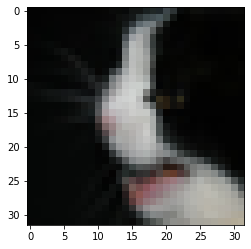

label: cat


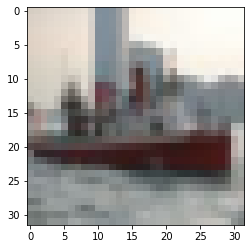

label: ship


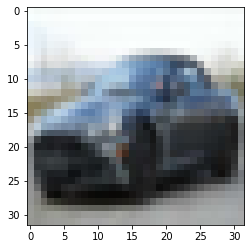

label: automobile


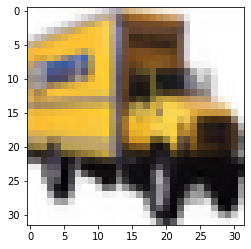

label: truck


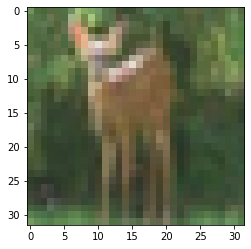

label: deer


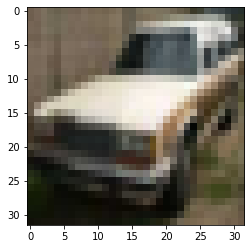

label: automobile


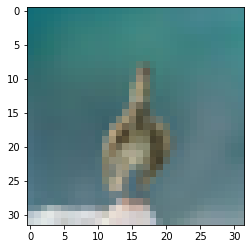

label: bird


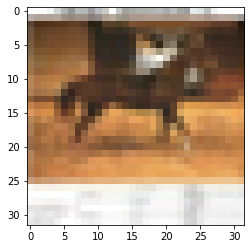

label: horse


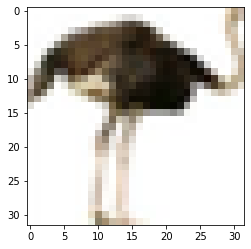

label: bird


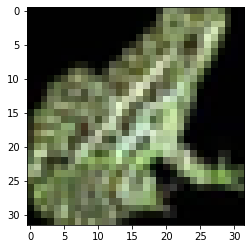

label: frog


In [ ]:
# Even with the provided data loader, we need a transform function which turns a PIL image into a pytorch tensor
# and optionally performs data augmentation.
transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
# Automatically download the dataset and get a data loader with torchvision
train_set = torchvision.datasets.CIFAR10(root='dataset', train=True, download=True, transform=transforms)
test_set = torchvision.datasets.CIFAR10(root='dataset', train=False, download=True, transform=transforms)

# Divide the training data into training and validation set
train_indices = range(len(train_set))
validation_indices = random.sample(train_indices, k = int(len(train_set)*0.1))
train_indices = set(train_indices) - set(validation_indices)
validation_set = torch.utils.data.Subset(dataset=train_set, indices=list(validation_indices))
train_set = torch.utils.data.Subset(dataset=train_set, indices=list(train_indices))

print(f'Dataset size: train: {len(train_set)}, validation: {len(validation_set)}, test: {len(test_set)}')

# Now that we have datasets, we need dataloaders which iterate through and batches data. This is pretty straightforward.
def get_data_loaders(batch_size):
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)
    val_loader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)
    return train_loader, val_loader, test_loader

print("Before we dive in further, let's take a look at our training data.")
for i in range(10):
    sample_image, sample_label = random.choice(train_set)
    utils.display_pt_img(sample_image, zoom=True)
    print(f'label: {CLASSES[sample_label]}')

## 6. The Training Loop

You should now have an operational network and only one step remains: the training! 

Training a NN is done iteratively: the dataset is split in batches. Everytime a *batch* goes through the network we'll refer to it as an **iteration**, and everytime the *dataset* has completely gone through (over multiple batches thus iterations), an **epoch**.

During the iteration a batch will go through the network to make predictions (=**forward pass**), and gradients will be computed based on the prediction errors (=**backward pass**). Those gradients are computed *numerically* by Pytorch. Finally the **weights** are updated by the **optimizer** (in our case ADAM) in order to reduce the final loss. This process is repeated until convergence (or a maximal number of epochs) has been reached.


--- Starting epoch 0
Average train loss: 1.6066132638264785
Validating...
Average validation loss: 1.3963346287608147

-Ending epoch 0: elapsed time 12.683523654937744

--- Starting epoch 1
Average train loss: 1.2297250162810087
Validating...
Average validation loss: 1.176282824575901

-Ending epoch 1: elapsed time 12.49238109588623

--- Starting epoch 2
Average train loss: 1.0579685219986872
Validating...
Average validation loss: 1.056791116297245

-Ending epoch 2: elapsed time 12.421936988830566

--- Starting epoch 3
Average train loss: 0.9405573193322528
Validating...
Average validation loss: 0.9665338933467865

-Ending epoch 3: elapsed time 12.374528646469116

--- Starting epoch 4
Average train loss: 0.855303711511872
Validating...
Average validation loss: 0.8995047137141228

-Ending epoch 4: elapsed time 12.2840256690979

--- Starting epoch 5
Average train loss: 0.7839553710073233
Validating...
Average validation loss: 0.8620847843587398

-Ending epoch 5: elapsed time 12.404441833

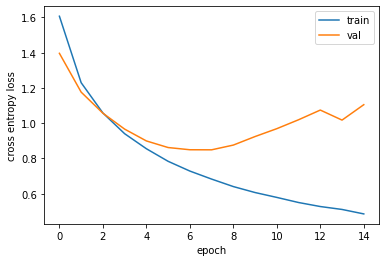

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda') #  Note: cuda is the name of the technology inside NVIDIA graphic cards
else:
    device = torch.device('cpu')
    print('warning: no cuda device detected, training will be extremely slow!'
          '(35 seconds per epoch on an AMD Ryzen Threadripper 3960X CPU)'
          'consider using colab: https://colab.research.google.com/')

def train_and_test_a_model(epochs: int, lr: float, batch_size: int, latent_channels: int):
    model = Classifier_CNN(num_classes=10, input_spatial_dimension=32, latent_channels=latent_channels)
    model = model.to(device) # Transfer Network on graphic card.

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Load the data
    train_loader, val_loader, test_loader = get_data_loaders(batch_size)

    loss_fun = torch.nn.CrossEntropyLoss()

    avg_train_losses = []
    avg_val_losses = []

    # Complete Training Loop
    for epoch in range(epochs):
        print(f"--- Starting epoch {epoch}")
        start = time.time()

        model.train() # Set the network in training mode => weights can be optimized

        current_train_losses = []  # keep track of the losses in a given epoch
        for batch in train_loader:
          images, labels = batch
          images, labels = images.to(device), labels.to(device)

          optimizer.zero_grad()  # (Re)Set all the gradients to zero
          predictions = model(images)  # Infer a batch through the network

          loss = loss_fun(predictions, labels)  # Compute the loss
          current_train_losses.append(loss.item())  # keep track of the losses in a given epoch
          loss.backward()  # Compute the backward pass based on the gradients and activations
          optimizer.step()  # Update the weights


        avg_train_losses.append(statistics.mean(current_train_losses))
        print(f"Average train loss: {avg_train_losses[-1]}")

         # Validate the model
        print("Validating...")
        current_validation_losses = []
        with torch.no_grad():
          model.eval() # Freeze the network >< training mode
          for batch in val_loader:
              images, labels = batch
              images, labels = images.to(device), labels.to(device)

              preds = model(images)
              current_validation_losses.append(loss_fun(preds, labels).item())
        avg_val_losses.append(statistics.mean(current_validation_losses))
        print(f"Average validation loss: {avg_val_losses[-1]}")

        end = time.time()

        # Print logging
        print(f"\n-Ending epoch {epoch}: elapsed time {end - start}\n")


    # Test the model on completely unseen data
    print("Testing...")
    test_losses = []
    with torch.no_grad():
      model.eval()
      for batch in test_loader:
          images, labels = batch
          images, labels = images.to(device), labels.to(device)

          preds = model(images)
          test_losses.append(loss_fun(preds, labels).item())
    print(f"Average test loss: {statistics.mean(test_losses)}")

    plt.plot(avg_train_losses, label='train')
    plt.plot(avg_val_losses, label='val')
    plt.xlabel('epoch')
    plt.ylabel('cross entropy loss')
    plt.legend()
    torch.save(model, f'trained_model_{epoch}.pth')
    return model

model = train_and_test_a_model(epochs=15, lr=0.001, batch_size=128, latent_channels=64)

In [ ]:
# Feel free to perform more trainings without losing your previous results by adding more cells.

Hopefully these results show that your network is learning! But can you interpret the data? Perhaps you could break down the losses into per-class accuracy and see where your network is struggling. How do the training and validation losses behave and why?

Let's do some visual tests.


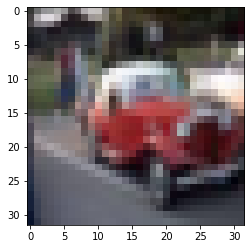

actual label: automobile, predicted label: truck


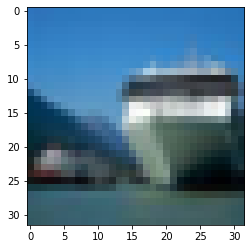

actual label: ship, predicted label: airplane


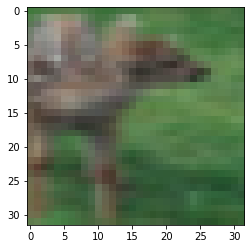

actual label: deer, predicted label: deer


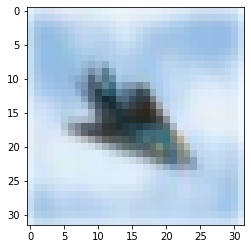

actual label: airplane, predicted label: airplane


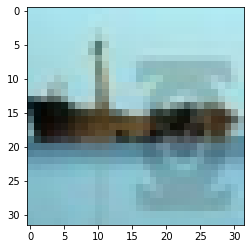

actual label: ship, predicted label: ship


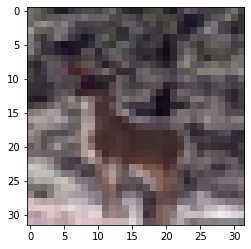

actual label: deer, predicted label: frog


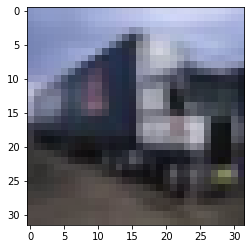

actual label: truck, predicted label: truck


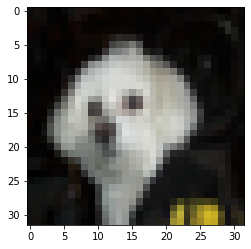

actual label: dog, predicted label: dog


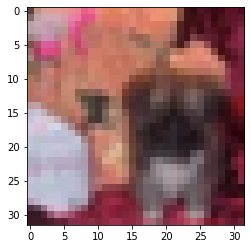

actual label: dog, predicted label: dog


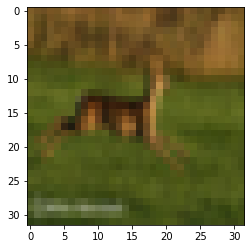

actual label: deer, predicted label: deer


In [ ]:
minitest_set = random.sample(list(test_set), k=10)

for sample_image, sample_label in minitest_set:
    utils.display_pt_img(sample_image, zoom=True)
    
    model_out = model(sample_image.unsqueeze(0).to(device))  # unsqueeze(0) adds a 1-dimension, which is the equivalent of a batch size of 1
    result = CLASSES[torch.argmax(model_out)]  # Take the class with the highest score, that is the network's prediction
    print(f'actual label: {CLASSES[sample_label]}, predicted label: {result}')

Hopefully your model performed well. But how robust is it? Let's mess with its input data and see how it holds up. :-)


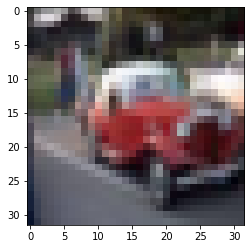

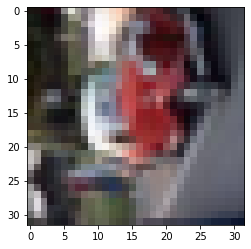

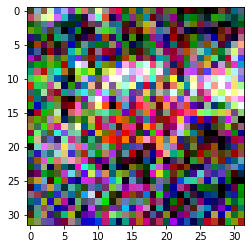

actual label: automobile, predicted label w/rotation: truck, w/noise: frog


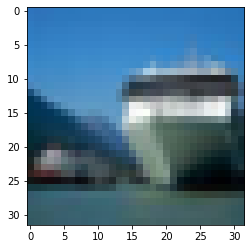

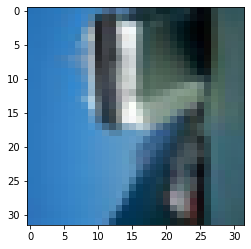

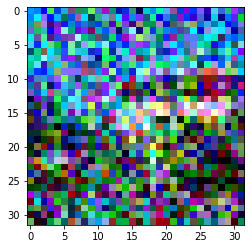

actual label: ship, predicted label w/rotation: bird, w/noise: airplane


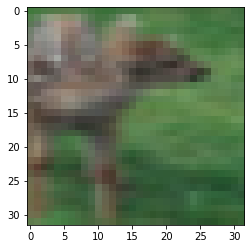

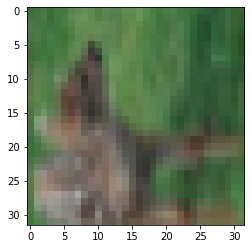

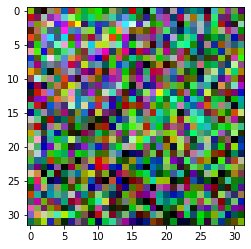

actual label: deer, predicted label w/rotation: deer, w/noise: frog


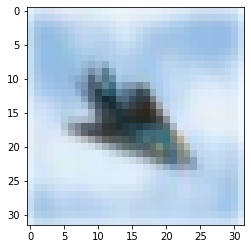

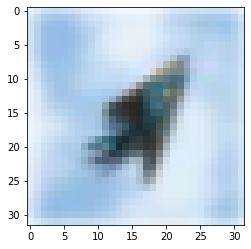

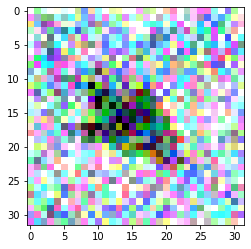

actual label: airplane, predicted label w/rotation: airplane, w/noise: deer


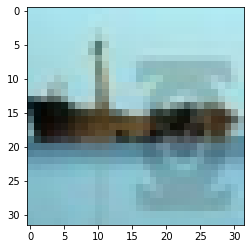

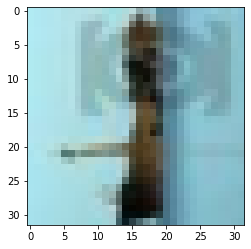

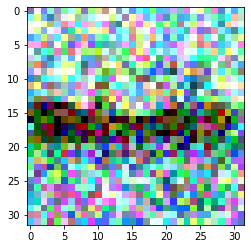

actual label: ship, predicted label w/rotation: bird, w/noise: frog


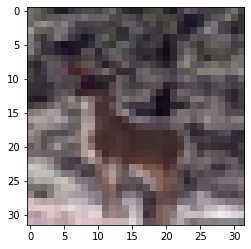

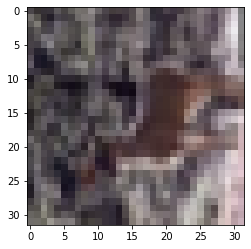

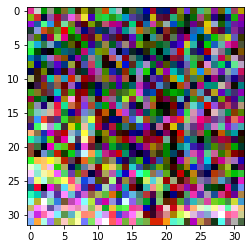

actual label: deer, predicted label w/rotation: deer, w/noise: horse


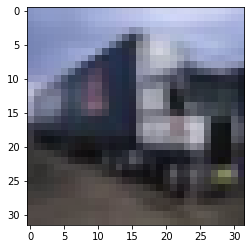

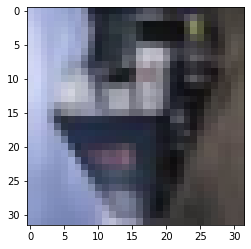

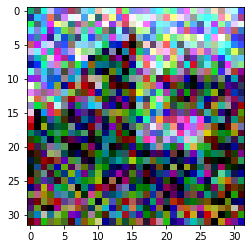

actual label: truck, predicted label w/rotation: automobile, w/noise: truck


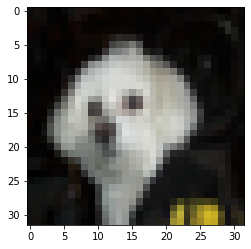

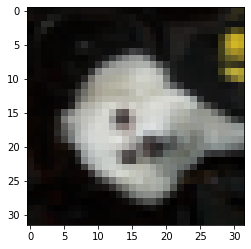

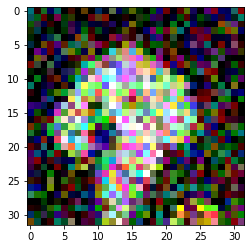

actual label: dog, predicted label w/rotation: dog, w/noise: frog


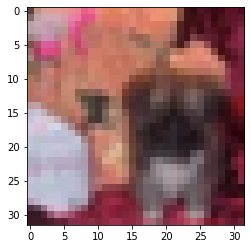

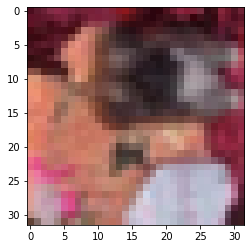

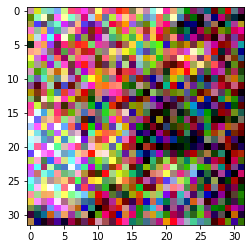

actual label: dog, predicted label w/rotation: dog, w/noise: cat


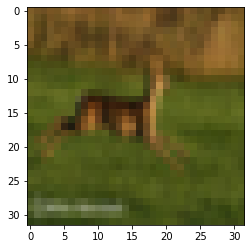

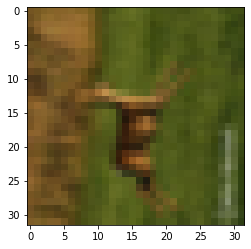

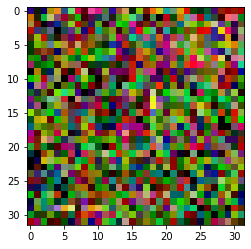

actual label: deer, predicted label w/rotation: deer, w/noise: frog


In [ ]:
for sample_image, sample_label in minitest_set:
    utils.display_pt_img(sample_image, zoom=True)
    
    rotated_image = torch.rot90(sample_image, 1, [1,2])
    utils.display_pt_img(rotated_image, zoom=True)
    model_out = model(rotated_image.unsqueeze(0).to(device))
    result_rot = CLASSES[torch.argmax(model_out)]
    
    noisy_image = noise_adder(sample_image).clip(0,1)
    utils.display_pt_img(noisy_image, zoom=True)
    model_out = model(noisy_image.unsqueeze(0).to(device))
    result_noisy = CLASSES[torch.argmax(model_out)]
    print(f'actual label: {CLASSES[sample_label]}, predicted label w/rotation: {result_rot}, w/noise: {result_noisy}')

Probably not so much. The good news is that you can easily improve your model's robustness by adding these kinds of "data augmentation" techniques to the input data during training. In fact your data loader already comes with a "transform" parameter just for that! Some examples of what you can do are listed on [torchvision.transforms](https://pytorch.org/vision/stable/transforms.html). Feel free to add transformations (like [torchvision.transforms.RandomRotation](https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.RandomRotation)) and try again.

We can also test the model on some out-of-distribution data that we collected ourselves. (Feel free to try this with your own cat!)


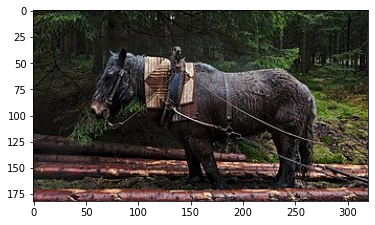

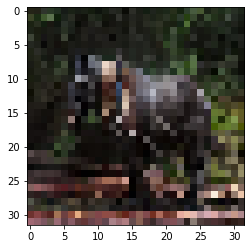

actual label: horse, predicted label: frog


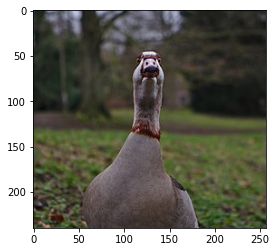

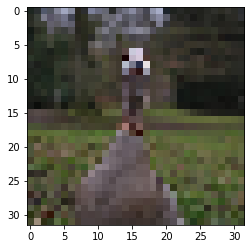

actual label: bird, predicted label: bird


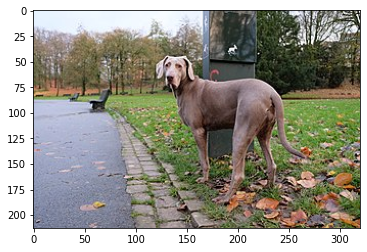

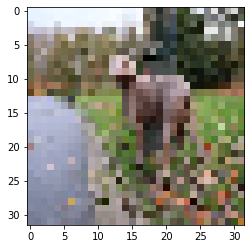

actual label: dog, predicted label: frog


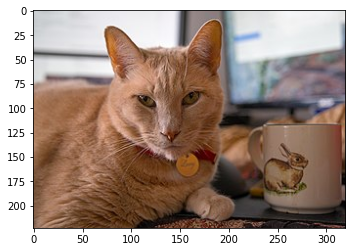

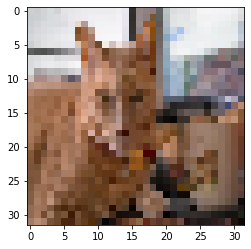

actual label: cat, predicted label: cat


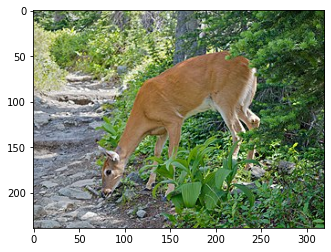

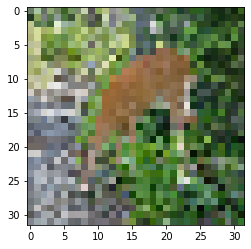

actual label: deer, predicted label: frog


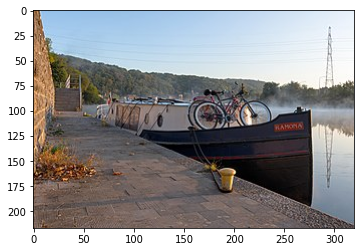

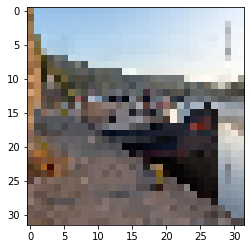

actual label: ship, predicted label: airplane


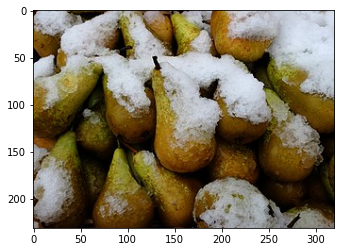

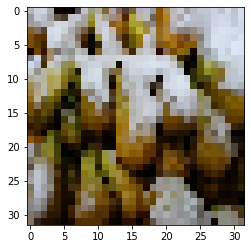

actual label: misc, predicted label: frog


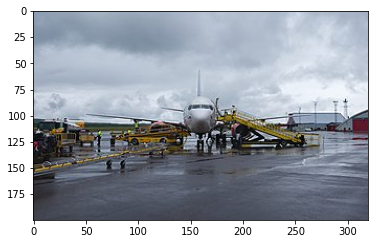

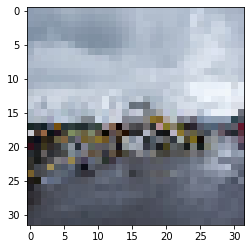

actual label: airplane, predicted label: airplane


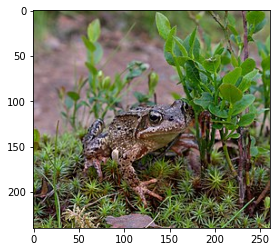

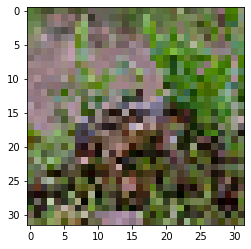

actual label: frog, predicted label: frog


In [ ]:
for actual_class in os.listdir('test_images'):
    img_fpath = utils.get_random_testimg_fpath(category=actual_class)  # get an image
    img_tensor = utils.img_fpath_to_pt_tensor(img_fpath)
    utils.display_pt_img(img_tensor, zoom=False)
    img_tensor_32 = torchvision.transforms.Resize((32,32))(img_tensor)  # resize to required 32x32px
    utils.display_pt_img(img_tensor_32, zoom=True)
    img_tensor_32 = img_tensor_32.to(device)  # move to GPU
    model_out = model(img_tensor_32.to(device))
    result = CLASSES[torch.argmax(model_out)]
    print(f'actual label: {actual_class}, predicted label: {result}')

How did the model perform? Why do you think that is? How would you improve its performance? Can you improve the model's performance without retraining it somehow? If so give it a shot.
Notice how the model predicted something for the "misc" "category" even though it cannot correctly classify it? Could this kind of behavior cause issues in real-life use-cases? How would you mitigate this?


In [ ]:
# Feel free to experiment further, e.g. maximize the model's performance and/or generalization,
# try with your own images, etc.


## 7. GradCam

We will now try to visualize **why** the Neural Network took a certain decision. One way to do this is through a process called `GradCam` which uses the gradients and forward activations to determine which part of the image was used for the final classification.

The code below is beyond the scope of this practical session, but *if you'd ever want to go deeper into the rabbit hole, here is the paper: https://arxiv.org/pdf/1610.02391.pdf*

Execute the cells below. Do you conclude that your network's answers are based on sensible features?


In [ ]:
"""
    Don't worry about this code, you don't need to understand it
"""
class GradCam:
    def __init__(self, model, layers):
        self.model = model
        self.layers = layers
        self.hooks = []
        self.fmap_pool = dict()
        self.grad_pool = dict()

        def forward_hook(module, input, output):
            self.fmap_pool[module] = output.detach().cpu()
        def backward_hook(module, grad_in, grad_out):
            self.grad_pool[module] = grad_out[0].detach().cpu()
        
        for layer in layers:
            self.hooks.append(layer.register_forward_hook(forward_hook))
            self.hooks.append(layer.register_backward_hook(backward_hook))

    def close(self):
        for hook in self.hooks:
            hook.remove()

    def __enter__(self):
        return self

    def __exit__(self, type, value, traceback):
        self.close()

    def __call__(self, *args, **kwargs):
        self.model.zero_grad()
        return self.model(*args, **kwargs)

    def get(self, layer):
        assert layer in self.layers, f'{layer} not in {self.layers}'
        fmap_b = self.fmap_pool[layer] # [B, N, H, W]
        grad_b = self.grad_pool[layer] # [B, N, H, W]
        
        grad_b = torch.nn.functional.adaptive_avg_pool2d(grad_b, (1, 1)) # [B, N, 1, 1]
        gcam_b = (fmap_b * grad_b).sum(dim=1, keepdim=True) # [B, 1, H, W]
        gcam_b = torch.nn.functional.relu(gcam_b)

        return gcam_b

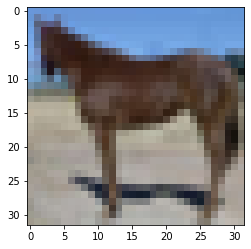

correct label = horse
maxval,ind = 18.190338134765625, 7 => horse


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


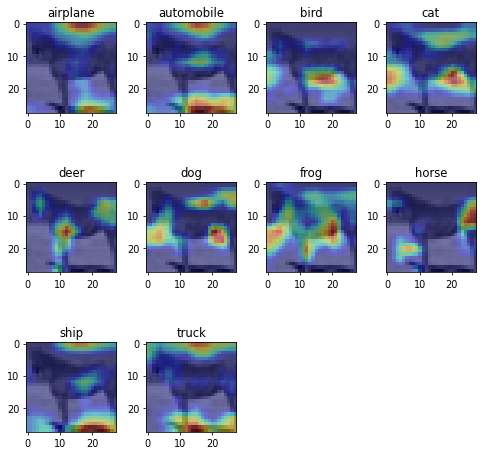

In [ ]:
# Select image to analyze
k = random.choice(range(len(test_set)))
batch = test_set[k]
orig_img = batch[0]
utils.display_pt_img(orig_img, zoom=True)
t_label = CLASSES[batch[1]]
print(f'correct label = {t_label}')

img = orig_img.clone().detach().requires_grad_(True) # Make Tensor
img = img.unsqueeze(dim=0)  # [1, 28, 28] -> [1, 1, 28, 28]
img = img.to(device)  # move to gpu

img2 =  np.stack((orig_img[0],)*3, axis=-1)

# Initializing & executing gradcam
#layerList = [model.convs[i] for i in range(len(model.convs))]
layerList = [model.convolution1, model.convolution2, model.convolution3, model.convolution4]
with GradCam(model, layerList) as gcam:
    out_b = gcam(img) # [B, N]
    maxval,ind = torch.max(out_b[0],0)
    print(f'maxval,ind = {maxval}, {ind} => {CLASSES[ind]}')
    fig=plt.figure(figsize=(7,7), dpi=70)
    
    for i, label in enumerate(CLASSES):
        out_b[:, i].backward(retain_graph=True)

        gcam_b = gcam.get(model.convolution4) # [B, 1, H, W]    
        gcam_b = torch.nn.functional.interpolate(gcam_b, [28, 28], mode='bilinear', align_corners=False) # [B, 1, H, W]

        plt.subplot(len(CLASSES)//4+1,4,i+1)
        plt.imshow(img2,alpha=1)
        plt.imshow(gcam_b[0,0],cmap='jet',alpha=0.4)
        plt.title(f"{label}")

plt.tight_layout()
plt.show()
